In [ ]:
#importing the required libraries
import tensorflow as tf
import tarfile
import urllib
import os
import numpy as np
import pets

from matplotlib import pyplot as plt
%matplotlib inline

data_dir = 'data/'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

#checking the version of tensorflow 
print('TensorFlow version:', tf.__version__)
#to check whether GPU is availabe or not
print('Is using GPU?', tf.test.is_gpu_available())

TensorFlow version: 2.0.1
Is using GPU? False


In [ ]:
#we will use cots vs dogs dataset
pets.download_and_extract('data', '.')
#we will use the helper function to download the dataset in current directory and extract it to data directory

Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz


In [ ]:
class_to_index = {'cat': 0, 'dog': 1}
index_to_class = {0: 'cat', 1: 'dog'}
#index to class and class to index mappings

#using the helper function for getting the annotations
train_annot, count_train = pets.cats_vs_dogs_annotations('data/annotations/trainval.txt')
test_annot, count_test = pets.cats_vs_dogs_annotations('data/annotations/test.txt')

print('training examples: ',count_train)
print('test examples: ', count_test)

training examples:  3680
test examples:  3669


In [ ]:
#to see how annotations look like
test_annot

{'Abyssinian_201.jpg': 'cat',
 'Abyssinian_202.jpg': 'cat',
 'Abyssinian_204.jpg': 'cat',
 'Abyssinian_205.jpg': 'cat',
 'Abyssinian_206.jpg': 'cat',
 'Abyssinian_207.jpg': 'cat',
 'Abyssinian_20.jpg': 'cat',
 'Abyssinian_210.jpg': 'cat',
 'Abyssinian_212.jpg': 'cat',
 'Abyssinian_213.jpg': 'cat',
 'Abyssinian_215.jpg': 'cat',
 'Abyssinian_216.jpg': 'cat',
 'Abyssinian_217.jpg': 'cat',
 'Abyssinian_219.jpg': 'cat',
 'Abyssinian_21.jpg': 'cat',
 'Abyssinian_220.jpg': 'cat',
 'Abyssinian_221.jpg': 'cat',
 'Abyssinian_223.jpg': 'cat',
 'Abyssinian_224.jpg': 'cat',
 'Abyssinian_225.jpg': 'cat',
 'Abyssinian_226.jpg': 'cat',
 'Abyssinian_228.jpg': 'cat',
 'Abyssinian_22.jpg': 'cat',
 'Abyssinian_230.jpg': 'cat',
 'Abyssinian_232.jpg': 'cat',
 'Abyssinian_24.jpg': 'cat',
 'Abyssinian_25.jpg': 'cat',
 'Abyssinian_26.jpg': 'cat',
 'Abyssinian_27.jpg': 'cat',
 'Abyssinian_29.jpg': 'cat',
 'Abyssinian_2.jpg': 'cat',
 'Abyssinian_30.jpg': 'cat',
 'Abyssinian_31.jpg': 'cat',
 'Abyssinian_32.jpg': 

In [ ]:
#directory where the images are stored
image_dir = 'data/images/'
#to get a random batch of the images from the dataset
def get_random_batch(annot, batch_size = 4):
    all_keys = list(annot.keys())
    total_examples = len(all_keys)
    
    indices = np.random.choice(range(total_examples), batch_size)
    
    x = np.zeros((batch_size, 128, 128, 3))
    #since we will use mobilenet v2, so we have to choose the fix shape of the image
    y = np.zeros((batch_size, 1))
    images = []
    
    for i,index in enumerate(indices):
        image_path = os.path.join(image_dir, all_keys[index])
        #we will use keras preprocessing image module to load the image and take it in a specific target size
        image = tf.keras.preprocessing.image.load_img(
            image_path, target_size = (128, 128)
        )
        arr = tf.keras.preprocessing.image.img_to_array(image)
        #to convert the image into the array
        arr = tf.keras.applications.mobilenet_v2.preprocess_input(arr)
        #since in transfer learning we are using mobilenet v2 so we will preprocess the image accordingly
        arr = np.expand_dims(arr, axis = 0)
        x[i] = arr
        y[i] = class_to_index[annot[all_keys[index]]]
        #taking the labels in numeric form with the help of mapping
        images.append(image)
        
    return x, y ,images

Displaying first 8 examples..


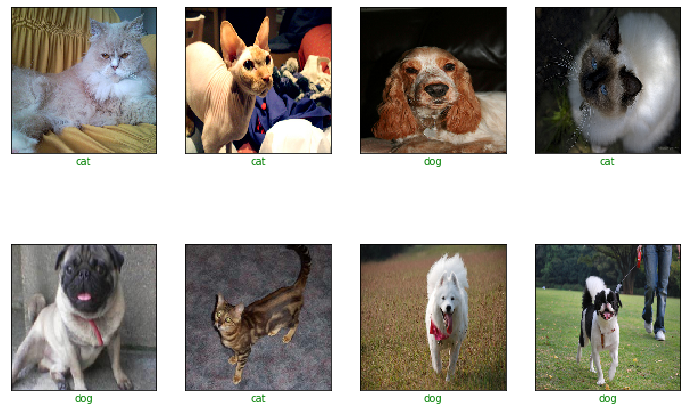

In [ ]:
x, y, images = get_random_batch(train_annot, batch_size = 8)
#using helper function to visualize the images
pets.display_examples(x, y ,y, images, index_to_class).show()

In [ ]:
#to create the model
mnet = tf.keras.applications.mobilenet_v2.MobileNetV2(
    include_top = False,
    pooling = 'avg',
    weights = 'imagenet',
    input_shape = (128, 128 , 3)
)
mnet.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [ ]:
#adding the additional layer in the model
def create_model():
    model = tf.keras.models.Sequential([
        mnet,
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])
    model.layers[0].trainable = False
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam',
                 metrics = ['accuracy'])
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
#training of the model
def data_generator(batch_size, annot):
    while True:
        x, y, _ = get_random_batch(annot, batch_size)
        yield (x,y)

In [ ]:
batch_size = 32
steps_per_epoch = int(count_train/batch_size)
validation_steps = int(count_test/batch_size)

print('Training steps: ', steps_per_epoch)
print('Validation steps: ', validation_steps)
#setting up the training parameters

Training steps:  115
Validation steps:  114


In [ ]:
%%time

_ = model.fit_generator(
    data_generator(batch_size, train_annot),
    validation_data = data_generator(batch_size, test_annot),
    steps_per_epoch = steps_per_epoch,
    validation_steps = validation_steps,
    epochs = 1
)
#training the model, we have to go the data through once only since we are using mobile net as transfer learning

115/115 [==============================] - 1098s 10s/step - loss: 0.4134 - accuracy: 0.8133 - val_loss: 0.1446 - val_accuracy: 0.9515
Wall time: 18min 18s


In [ ]:
#prediction of model
x, y, images = get_random_batch(test_annot, batch_size = 8)
pred = model.predict(x)

Displaying first 8 examples..


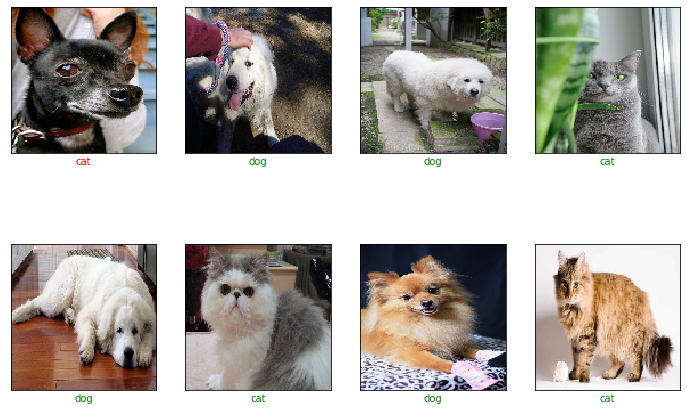

In [ ]:
#plotting the model predictios
pets.display_examples(x, y, pred, images, index_to_class).show()